# INFSCI 1520 Final Project Visualization Notebook

This notebook generates all visualizations for the final report on Alzheimer's and Mental Distress.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
df = pd.read_csv("alzheimer_s_disease_and_healthy_aging_data.csv")

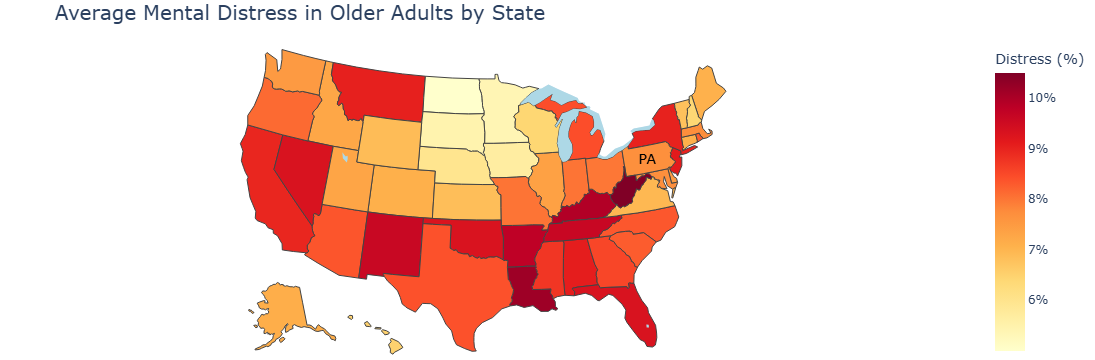

In [45]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load dataset
df = pd.read_csv("alzheimer_s_disease_and_healthy_aging_data.csv")

# Filter for 65+ mental distress data
distress_df = df[
    (df['Topic'] == 'Frequent mental distress') &
    (df['StratificationID1'] == '65PLUS') &
    (df['Data_Value'].notna())
][['YearStart', 'LocationAbbr', 'LocationDesc', 'Data_Value']]
distress_df.columns = ['Year', 'StateAbbr', 'StateName', 'MentalDistress']

# Average distress by state
avg_distress = distress_df.groupby(['StateAbbr', 'StateName'])['MentalDistress'].mean().reset_index()

# Create base choropleth
fig = px.choropleth(
    avg_distress,
    locations='StateAbbr',
    locationmode="USA-states",
    color='MentalDistress',
    hover_name='StateName',
    color_continuous_scale='YlOrRd',  # More noticeable gradient
    scope="usa",
    labels={'MentalDistress': 'Avg % Distress (65+)'},
    title="Average Mental Distress in Older Adults by State"
)

# Add annotation for Pennsylvania
pa_row = avg_distress[avg_distress['StateAbbr'] == 'PA'].iloc[0]
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=[-77.86],
    lat=[40.79],
    text=["PA"],
    mode='text',
    textfont=dict(size=14, color='black')
))

# Update layout
fig.update_layout(
    geo=dict(showlakes=True, lakecolor='lightblue'),
    title_font_size=20,
    margin={"r":0,"t":40,"l":0,"b":0},
    coloraxis_colorbar=dict(title="Distress (%)", ticksuffix="%")
)

# Show the map
fig.show()



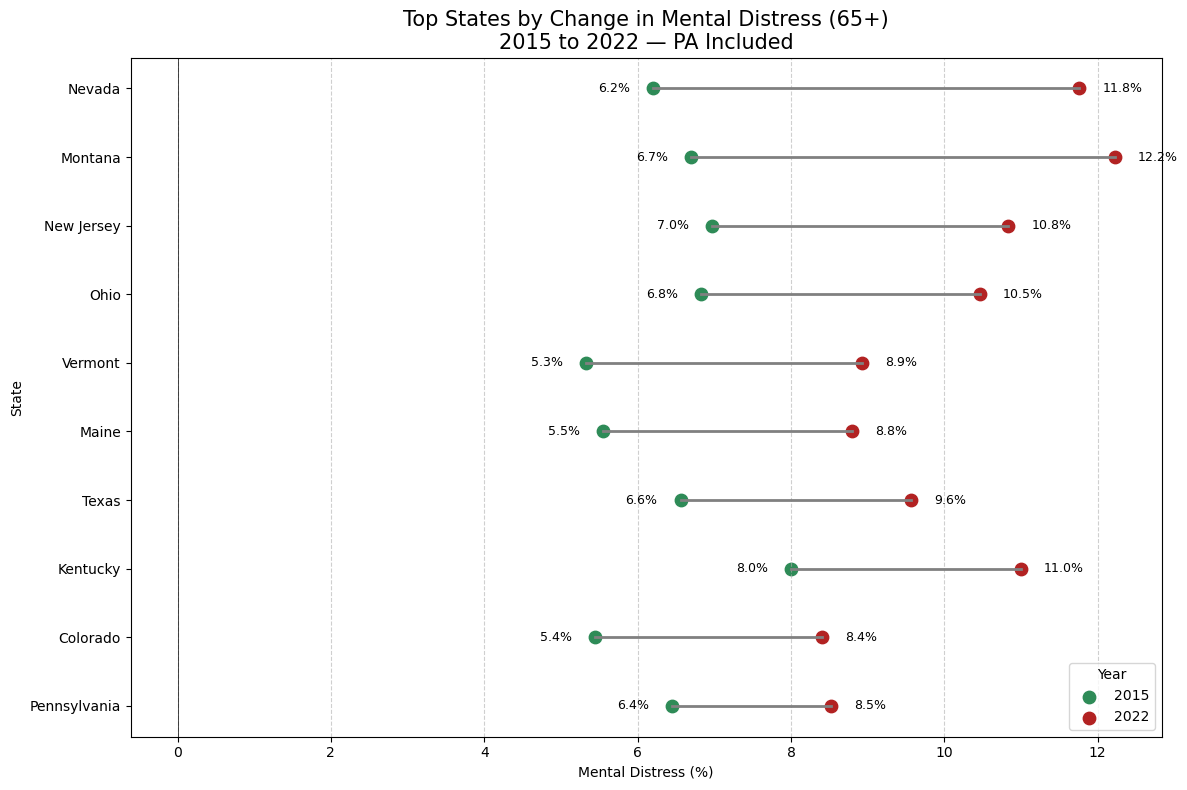

In [31]:
import matplotlib.pyplot as plt

# List of valid U.S. states
valid_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
    'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia',
    'Wisconsin', 'Wyoming'
]

# Filter dataset
distress_cleaned = distress_df[distress_df['StateName'].isin(valid_states)]

# Get earliest/latest years
earliest_year = distress_cleaned['Year'].min()
latest_year = distress_cleaned['Year'].max()

# Compute mean distress per state per year
before = distress_cleaned[distress_cleaned['Year'] == earliest_year].groupby('StateName')['MentalDistress'].mean().reset_index()
after = distress_cleaned[distress_cleaned['Year'] == latest_year].groupby('StateName')['MentalDistress'].mean().reset_index()

# Merge and compute change
dumbbell_df = pd.merge(before, after, on='StateName', suffixes=('_Before', '_After'))
dumbbell_df['Change'] = dumbbell_df['MentalDistress_After'] - dumbbell_df['MentalDistress_Before']

# Always include Pennsylvania + top 9 other states
top_states = dumbbell_df.loc[dumbbell_df['StateName'] != 'Pennsylvania']\
    .reindex(dumbbell_df.loc[dumbbell_df['StateName'] != 'Pennsylvania']['Change'].abs().sort_values(ascending=False).index[:9])
pa_row = dumbbell_df[dumbbell_df['StateName'] == 'Pennsylvania']
top_dumbbell_df = pd.concat([top_states, pa_row]).sort_values('Change')

# Plot
plt.figure(figsize=(12, 8))
for i, row in top_dumbbell_df.iterrows():
    plt.plot([row['MentalDistress_Before'], row['MentalDistress_After']], [row['StateName']] * 2, color='gray', lw=2)
    plt.scatter(row['MentalDistress_Before'], row['StateName'], color='seagreen', s=80, label=str(earliest_year) if i == top_dumbbell_df.index[0] else "")
    plt.scatter(row['MentalDistress_After'], row['StateName'], color='firebrick', s=80, label=str(latest_year) if i == top_dumbbell_df.index[0] else "")
    plt.text(row['MentalDistress_Before'] - 0.3, row['StateName'], f"{row['MentalDistress_Before']:.1f}%", va='center', ha='right', fontsize=9)
    plt.text(row['MentalDistress_After'] + 0.3, row['StateName'], f"{row['MentalDistress_After']:.1f}%", va='center', ha='left', fontsize=9)

plt.axvline(0, color='black', linewidth=0.5)
plt.title(f"Top States by Change in Mental Distress (65+)\n{earliest_year} to {latest_year} — PA Included", fontsize=15)
plt.xlabel("Mental Distress (%)")
plt.ylabel("State")
plt.legend(title="Year", loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


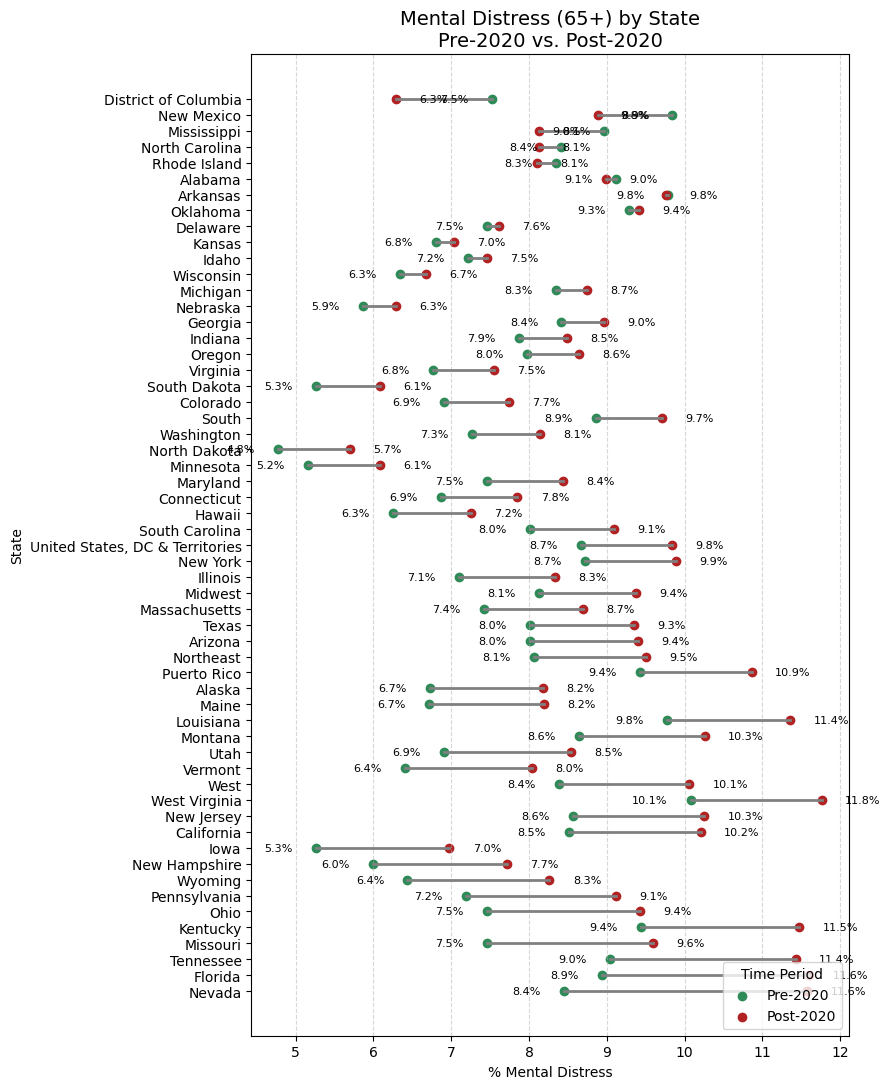

In [51]:
import matplotlib.pyplot as plt

# Filter out Guam and D.C.
compare_df_filtered = compare_df[
    (~compare_df['StateName'].str.contains("Guam", case=False, na=False))
].copy()

# Plot dumbbell chart
plt.figure(figsize=(9, 11))
for i, row in compare_df_filtered.iterrows():
    # Line connecting pre and post
    plt.plot([row['Pre2020'], row['Post2020']], [row['StateName']] * 2, color='gray', lw=2)

    # Dots
    plt.scatter(row['Pre2020'], row['StateName'], color='seagreen', label='Pre-2020' if i == 0 else "")
    plt.scatter(row['Post2020'], row['StateName'], color='firebrick', label='Post-2020' if i == 0 else "")

    # Text labels
    plt.text(row['Pre2020'] - 0.3, row['StateName'], f"{row['Pre2020']:.1f}%", va='center', ha='right', fontsize=8)
    plt.text(row['Post2020'] + 0.3, row['StateName'], f"{row['Post2020']:.1f}%", va='center', ha='left', fontsize=8)

# Styling
plt.title("Mental Distress (65+) by State\nPre-2020 vs. Post-2020", fontsize=14)
plt.xlabel("% Mental Distress")
plt.ylabel("State")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title='Time Period', loc='lower right')
plt.tight_layout()
plt.show()


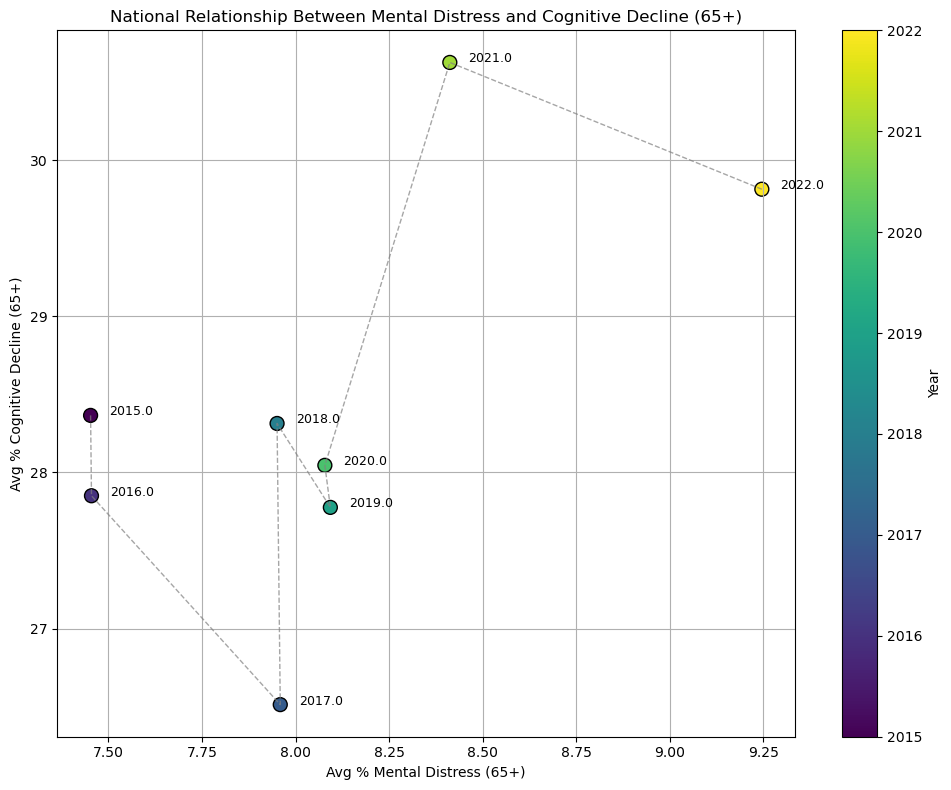

In [35]:
# Prepare national averages
distress_national = distress_df.groupby('Year')['MentalDistress'].mean().reset_index()
distress_national.columns = ['Year', 'Avg_Mental_Distress']

alz_df = df[
    (df['Topic'].str.contains("Subjective cognitive decline", case=False, na=False)) &
    (df['StratificationID1'] == '65PLUS') &
    (df['Data_Value'].notna())
]
alz_national = alz_df.groupby('YearStart')['Data_Value'].mean().reset_index()
alz_national.columns = ['Year', 'Avg_Cognitive_Decline']

# Merge datasets
scatter_df = pd.merge(distress_national, alz_national, on='Year', how='inner')

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    scatter_df['Avg_Mental_Distress'],
    scatter_df['Avg_Cognitive_Decline'],
    c=scatter_df['Year'],
    cmap='viridis',
    s=100,
    edgecolor='black'
)

# Connect points with line
plt.plot(
    scatter_df['Avg_Mental_Distress'],
    scatter_df['Avg_Cognitive_Decline'],
    color='gray',
    linestyle='--',
    linewidth=1,
    alpha=0.7
)

# Annotate each point with the year
for i, row in scatter_df.iterrows():
    plt.text(row['Avg_Mental_Distress'] + 0.05, row['Avg_Cognitive_Decline'], str(row['Year']), fontsize=9)

plt.xlabel("Avg % Mental Distress (65+)")
plt.ylabel("Avg % Cognitive Decline (65+)")
plt.title("National Relationship Between Mental Distress and Cognitive Decline (65+)")
cbar = plt.colorbar(scatter)
cbar.set_label("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


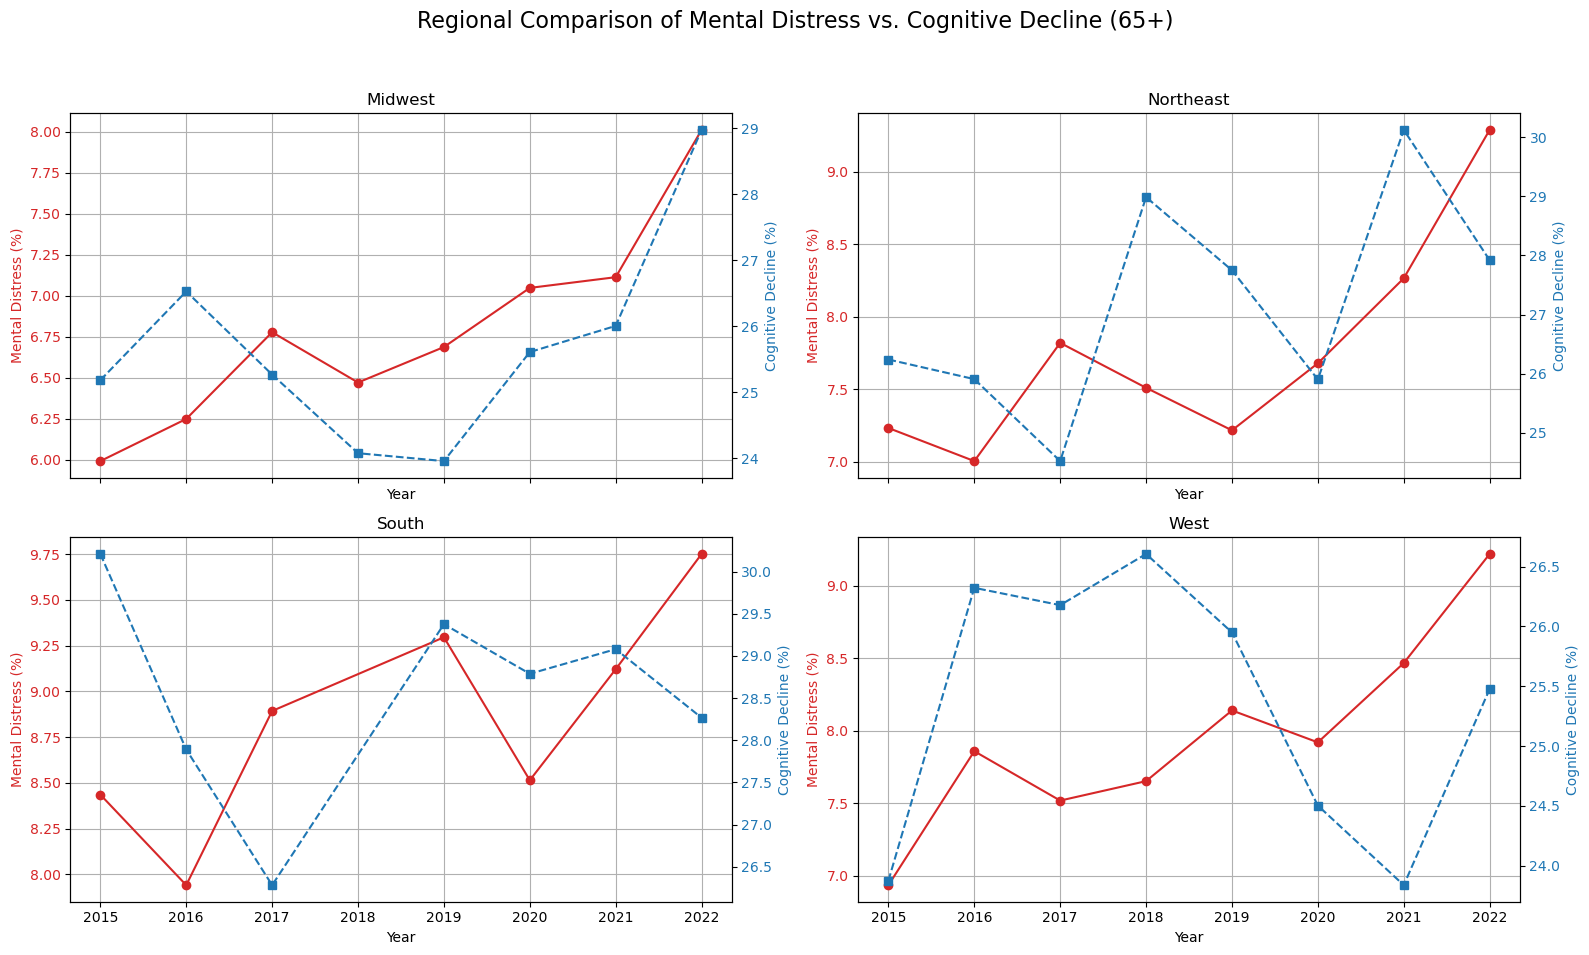

In [39]:
# One subplot per region: dual-axis (mental distress + cognitive decline)
regions = combo['Region'].unique()
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
axs = axs.flatten()
colors = {'MentalDistress': 'tab:red', 'CognitiveDecline': 'tab:blue'}

for i, region in enumerate(regions):
    ax1 = axs[i]
    region_data = combo[combo['Region'] == region]

    # Left y-axis: mental distress
    ax1.plot(region_data['Year'], region_data['MentalDistress'], color=colors['MentalDistress'], marker='o', label='Mental Distress')
    ax1.set_ylabel("Mental Distress (%)", color=colors['MentalDistress'])
    ax1.tick_params(axis='y', labelcolor=colors['MentalDistress'])
    ax1.set_title(region)

    # Right y-axis: cognitive decline
    ax2 = ax1.twinx()
    ax2.plot(region_data['Year'], region_data['Avg_Cognitive_Decline'], color=colors['CognitiveDecline'], marker='s', linestyle='--', label='Cognitive Decline')
    ax2.set_ylabel("Cognitive Decline (%)", color=colors['CognitiveDecline'])
    ax2.tick_params(axis='y', labelcolor=colors['CognitiveDecline'])

    ax1.set_xlabel("Year")
    ax1.grid(True)

# Layout and title
fig.suptitle("Regional Comparison of Mental Distress vs. Cognitive Decline (65+)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
